### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


## Processing MCMC

In [181]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import functions
#%run ./loop_showcase_functions.ipynb  # Contains project specific functions
    
sys.path.append('../../MODFLOW_Tools')    
logfunc = lambda e: np.log10(e)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Reference Results

In [182]:
# Get times
data_set = pd.read_csv('../modelfiles/ref_past.csv', header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

data_set = pd.read_csv('../modelfiles/ref_future.csv', header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

#pickleoff = open('../results_for_paper/times.pkl','rb')
#times = pickle.load(pickleoff)
#pickleoff.close()

# Get Reference Parameter values
pickleoff = open('../results/reference.pkl','rb')
hk_ref, vk_ref, ss_ref, sy_ref = pickle.load(pickleoff)
pickleoff.close()
cp_ref = -100

# Get reference results
pickleoff = open('../results/ref_past.pkl','rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

pickleoff = open('../results/ref_future.pkl','rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

In [183]:
print('\nHk Reference')
for i in hk_ref: print(logfunc(i))
print('\nVk Reference')
for i in vk_ref: print(logfunc(i))
print('\nSs Reference')
for i in ss_ref: print(logfunc(i))
print('\nSy Reference')
print(sy_ref)
print('\nCPz Reference')
print(cp_ref)


Hk Reference
0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813

Vk Reference
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813

Ss Reference
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056

Sy Reference
[0.12, 0.1, 0.1, 0.1]

CPz Reference
-100


#### Load MCMC Results

In [184]:
# Load DREAM results
pickleoff = open('../results/dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open('../results/dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

dream_pars = [dream_pars_0, dream_pars_1, dream_pars_2, dream_pars_3, dream_pars_4]
dream_pars = np.array(dream_pars) 

pickleoff = open('../results/dream_results.pkl','rb') # dream_results (105, 5, 3, 42)
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

# Load MCMC settings
pickleoff = open('../results/MCMC.pkl','rb') # Load saved observations for future
Min, Mean, Max, nchains, npars, nburn = pickle.load(pickleoff)
pickleoff.close()

# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_pars shape ', dream_pars.shape)
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

dream_pars shape  (5, 327, 13)
dream_results shape (1130, 5, 3, 42)
ref_results shape (5, 3, 42)


#### Burn Samples override

In [186]:
nburn = 200 # Override original burns based on convergence graphs
nsamples = dream_pars.shape[1] - nburn
print('number of burn per chain = ', nburn, ' TOTAL BURN = ', nchains * nburn)
print('number of samples per chain = ', nsamples, 'TOTAL SAMPLES = ', nchains * nsamples)

number of burn per chain =  200  TOTAL BURN =  1000
number of samples per chain =  127 TOTAL SAMPLES =  635


#### Look at MCMC chain convergence

(-250.0, 0.0)

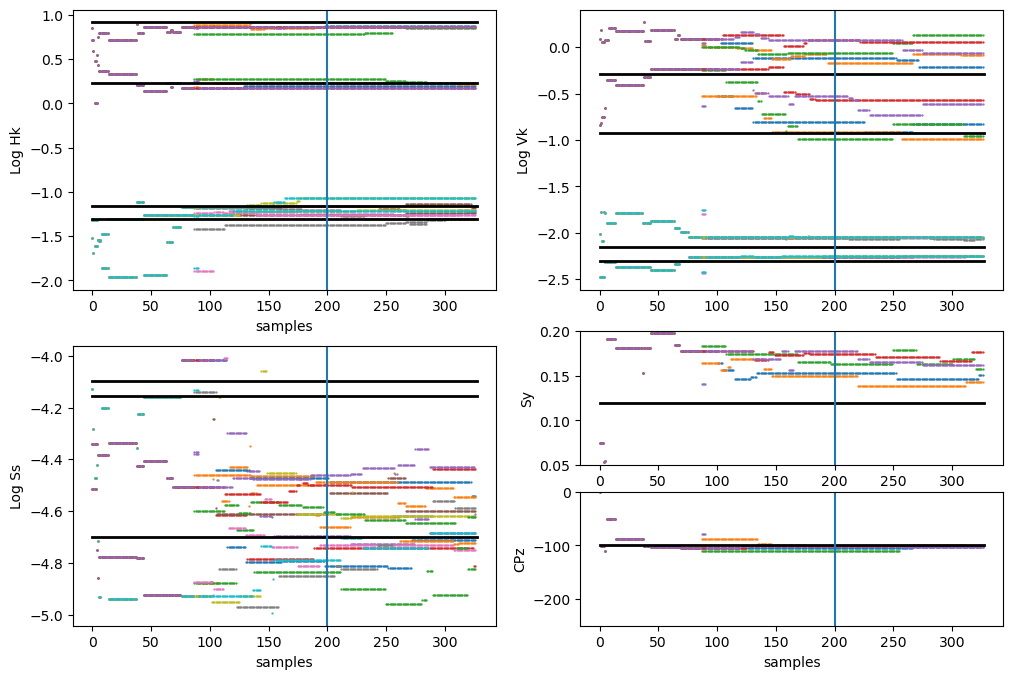

In [187]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(2,2,1)
for i in range(4):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o',ms=0.6)
for i in hk_ref: 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = 'black', lw = 2)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('Log Hk')
plt.axvline(nburn)
#plt.title('Hk convergence')

ax = plt.subplot(2,2,2)
for i in range(4,8):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o',ms=0.6)
for i in vk_ref: 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = 'black', lw = 2)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('Log Vk')
plt.axvline(nburn)
#plt.title('Vk convergence')
plt.xlabel(' ')

ax = plt.subplot(2,2,3)
for i in range(8,11):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o',ms=0.6)
for i in ss_ref[1:]: 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = 'black', lw = 2)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('Log Ss')
plt.axvline(nburn)
#plt.title('Ss convergence')

ax = plt.subplot(4,2,6)
for j in range(nchains):
    plt.plot(dream_pars[j,:,11], 'o',ms=0.6)
plt.plot((0, nburn+nsamples),(sy_ref[0], sy_ref[0]), color = 'black', lw = 2)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('Sy')
plt.axvline(nburn)
#plt.title('Sy convergence')
plt.ylim([0.05,0.2])

ax = plt.subplot(4,2,8)
for j in range(nchains):
    plt.plot(dream_pars[j,:,12], 'o',ms=0.6)
plt.plot((0, nburn+nsamples),(cp_ref, cp_ref), color = 'black', lw = 2)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('CPz')
plt.axvline(nburn)
#plt.title('CPz convergence')
plt.ylim([-250, 0])

### Plot parameter estimates

In [188]:
# Gaussian kernel desnsity estimation
from scipy import stats
x_pts, data, estimated_pdfs = [], [], []
for n in range(npars):
    d = dream_pars[:, nburn:, n].flatten()
    x = np.linspace(Min[n], Max[n], 200)
    gkde_obj = stats.gaussian_kde(d)
    
    data.append(d)
    x_pts.append(x)
    estimated_pdfs.append(gkde_obj.evaluate(x))

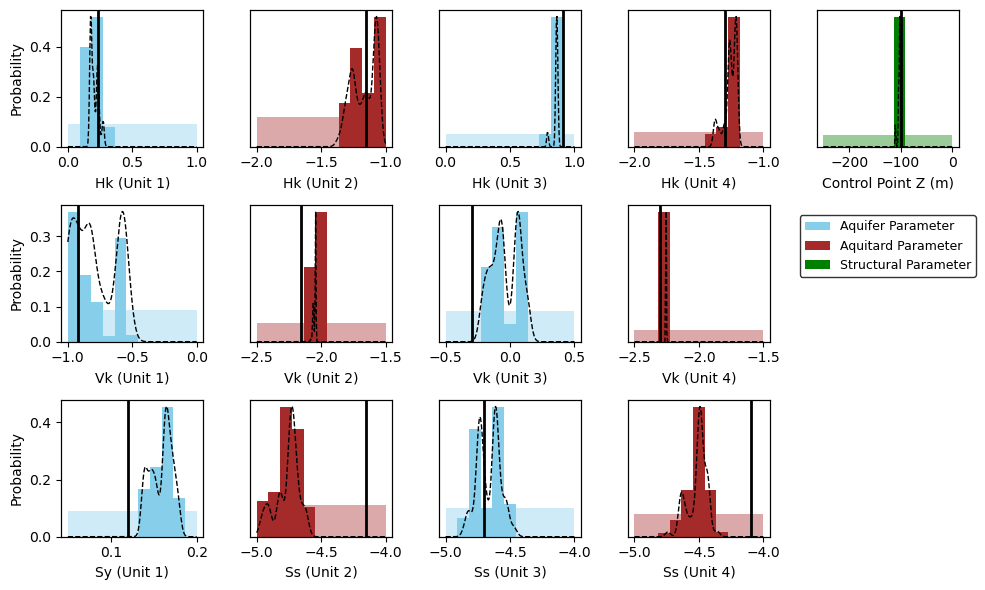

In [189]:
bins = 11

from matplotlib.ticker import AutoMinorLocator
fig, ax = plt.subplots(3,5, figsize = (10,6))

# Hk
for i in range(4):
    n = i # parameter number
    ax = plt.subplot(3,5,i+1)
    ax2 = ax.twinx()
    if i == 0 or i ==2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i ==1 or i ==3: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Hk (Unit {i+1})')
    if i == 0: ax.set_ylabel('Probability')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)

# Vk        
for i in range(4):
    n = i+4 # parameter number
    ax = plt.subplot(3,5,i+6)
    ax2 = ax.twinx()
    if i == 0 or i ==2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i ==1 or i ==3: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Vk (Unit {i+1})')
    if i == 0: ax.set_ylabel('Probability')
    #ax.set_ylim([0,nsamples*5])
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)
        
# Sy
n = 11 # parameter number
ax = plt.subplot(3,5,11)
ax2 = ax.twinx()
ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
plt.axvline(sy_ref[0], color = 'black', lw = 2)
ax.set_xlabel('Sy (Unit 1)')
ax.set_ylabel('Probability')
#ax.set_ylim([0,nsamples*5])
#ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,500])
ax2.set_yticks([])
ax2.set_ylim(bottom=0, top=None)

#Ss
for i in range(3):
    n = i+8 # parameter number
    ax = plt.subplot(3,5,i+12)
    ax2 = ax.twinx()
    if i == 0 or i == 2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i == 1: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(ss_ref[i+1]), color = 'black', lw = 2)
    ax.set_xlabel(f'Ss (Unit {i+2})')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    ax.set_yticks([])
    #ax.set_ylim([0,nsamples*5])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)

# CPz   
n = 12 
ax = plt.subplot(3,5,5)    
ax2 = ax.twinx()
ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'green', weights=1/len(data[n]) * np.ones(len(data[n])))
prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'green', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
plt.axvline(cp_ref, color = 'black', lw = 2)
ax.set_xlabel('Control Point Z (m)')
#ax.set_ylabel('Frequency')
#ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,nsamples*5])
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylim(bottom=0, top=None)

ax = plt.subplot(3,5,10) 
ax.set_axis_off()


import matplotlib.patches as mpatches
A = mpatches.Patch(facecolor = 'skyblue', edgecolor='none', label='Aquifer Parameter')
B = mpatches.Patch(facecolor = 'brown', edgecolor='none', label='Aquitard Parameter')
C = mpatches.Patch(facecolor = 'green', edgecolor='none', label='Structural Parameter')
ax.legend(handles=[A, B, C], loc="center", fontsize = 9, ncols = 1, edgecolor = 'black',
          bbox_to_anchor=[0.5, 0.7])#, title = 'Probability Contours of Injection Zone (Conc > 5mg/L)')

ax = plt.subplot(3,5,15) 
ax.set_axis_off()

#plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/fig9', dpi=450) 

In [190]:
import math
print('\nCP mean ', np.average(data[12]))
print('CPl std ', np.std(data[12]))



CP mean  -102.6646760500308
CPl std  2.692010569754339


### Compare predictions against reality

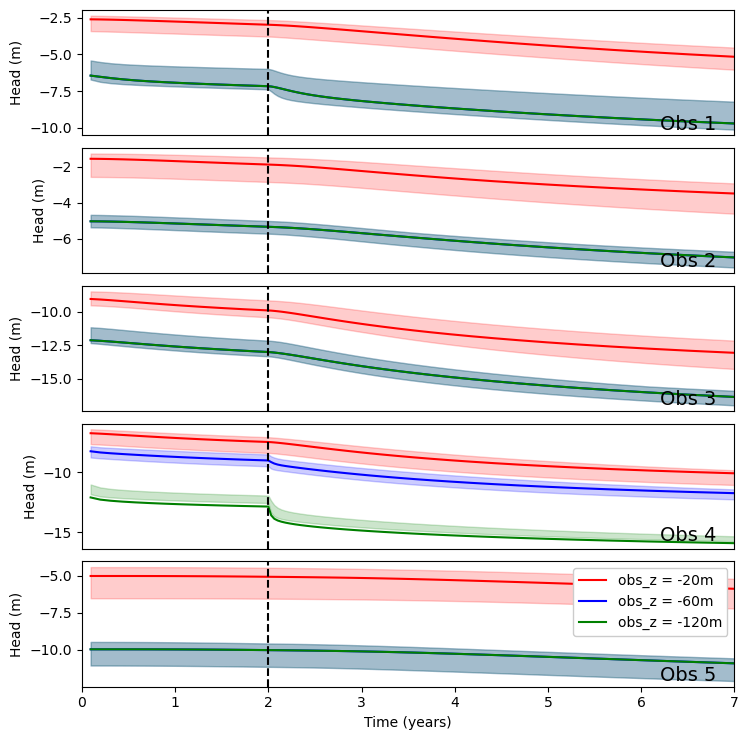

In [191]:
dream_results_0 = np.nanpercentile(dream_results, 0, axis=0)      # Find stacked minimum
dream_results_100 = np.nanpercentile(dream_results, 100, axis=0)  # Find stacked maximum

fig = plt.figure(figsize=(7.5,7.5))
colors = ['red', 'blue','green']
labels = ['obs_z = -20m', 'obs_z = -60m', 'obs_z = -120m']  
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    #ax.set_title('Obs %i' %(j))
    ax.annotate('Obs %i' %(j+1), (6.2, np.min(dream_results_0[j, k].flatten())), c='black', size = 14) #, weight = 'bold')    
    for k in range(3): # OBS in z
        ax.fill_between(times, dream_results_0[j, k], dream_results_100[j, k], color = colors[k], alpha = 0.2)        
        ax.plot(times, ref_results[j, k], lw = 1.5, label = labels[k], color = colors[k])
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2, color = 'black', ls = '--')
    if j ==4: ax.annotate('History matching phase', (0.1,-19), c='black', size = 10) #, weight = 'bold')   
    if j ==4: ax.annotate('Predictive phase', (2.3,-19), c='black', size = 10) #, weight = 'bold')   
    ax.set_xlim([0,7])
    #ax.set_ylim([-20,0])
    if j ==4: ax.legend(loc = 'upper right', framealpha = 1.0, facecolor="white")
    
plt.tight_layout()    
plt.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig('../figures/fig10', dpi=450) 

### Examine run times

In [192]:
pickleoff = open('../results/run_times.pkl','rb')
geo_model_runtime, flow_model_runtime = pickle.load(pickleoff)
pickleoff.close()

print(len(geo_model_runtime))

print('\nGeo model mean ', np.average(geo_model_runtime))
print('Geo model std ', np.std(geo_model_runtime))

print('\nFlow model mean ', np.average(flow_model_runtime))
print('Flow model std ', np.std(flow_model_runtime))

1637

Geo model mean  4.057225333536958
Geo model std  0.7675350193518209

Flow model mean  38.64441097678681
Flow model std  6.903293430085118


In [200]:
scrap code

SyntaxError: invalid syntax (2064385927.py, line 1)

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""